In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
grid_ids = ['5550','2972','5202','3215','5111']

def fetch_data(grid_ids):
    dfs = {}
    for i,df in enumerate(grid_ids):
        file_name = './data/selected_grids/Chosen_grids_data_add_class/'+grid_ids[i]+'.csv'      
        dfs[grid_ids[i]] = pd.read_csv(file_name,parse_dates=[0])
    return dfs

all_grids_data = fetch_data(grid_ids)

In [3]:
def calculate_mean(dfs,issue):
# according to hourly data
    means = []
    for key in list(dfs.keys()):
        mean = dfs[key].groupby(['hour'])[issue].mean()
        means.append(mean)
    return means
mean_consumption_all_grid = calculate_mean(all_grids_data,'current')


In [7]:
# for key, df in all_grids_data.items():
#     plt.figure(figsize=(20,10))
#     plt.plot(df.date)
#     plt.show()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


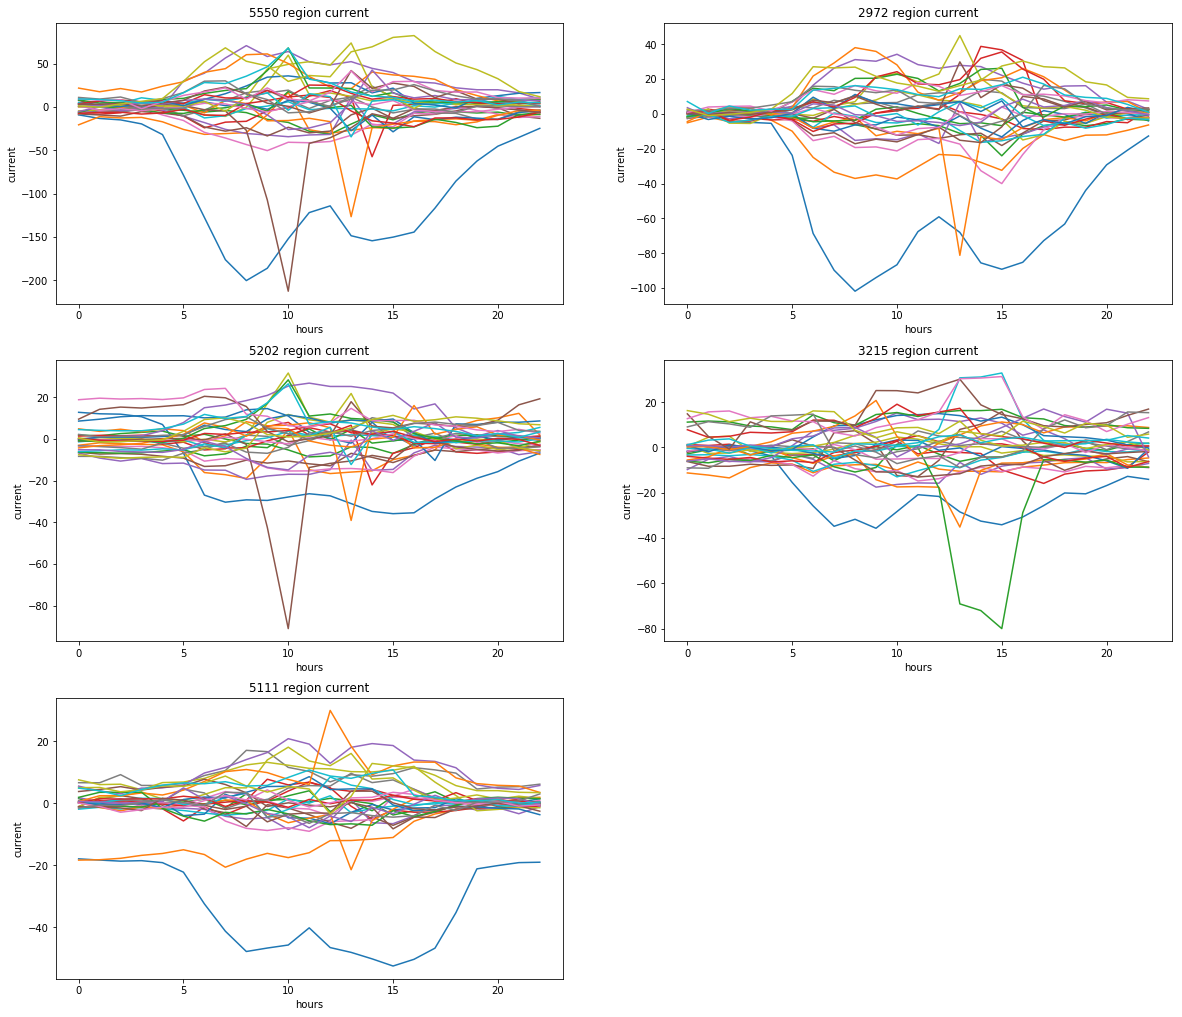

In [58]:
def plot_load_curve(df_dict):
    plt.figure(figsize=(20,30)) 
    k = 1
    for key,df in df_dict.items():
        print (type(df))
        plt.subplot(len(df_dict),2,k)
        k+=1
        current = df.groupby(['date','hour']).sum().unstack().current
        [plt.plot(np.arange(0,23),np.array(current.iloc[i,1:])) for i in range(len(current))]
        plt.title("%s region current"%key)
        plt.xlabel("hours")
        plt.ylabel("current")
plot_load_curve(all_grids_data)  
plt.show()

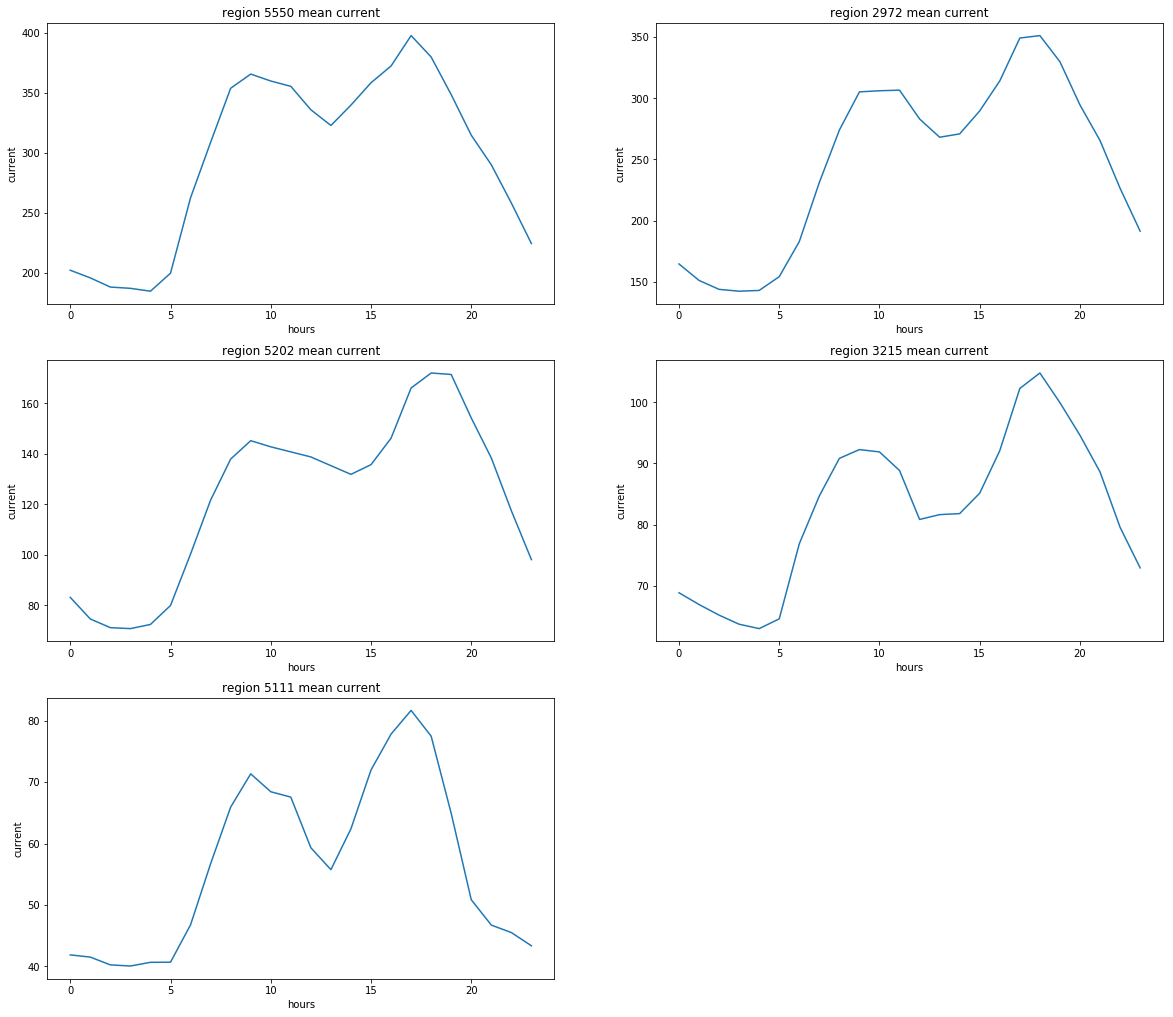

In [59]:
plt.figure(figsize=(20,30)) 
k = 1
for mean in mean_consumption_all_grid: 
    plt.subplot(len(mean_consumption_all_grid),2,k)
    plt.plot(mean)
    plt.xlabel("hours")
    plt.ylabel("current")
    plt.title("region %s mean current"%grid_ids[k-1]) 
    k+=1
plt.show()

matrix([[0, 1, 0, 1, 1],
        [1, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]], dtype=int64)

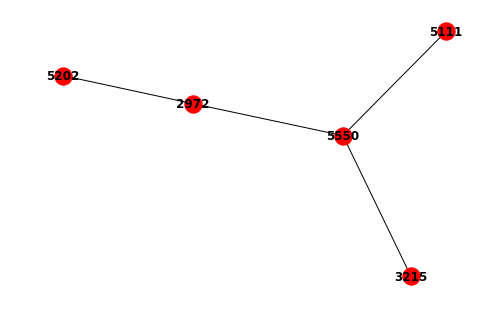

In [46]:
import networkx as nx
G1 = nx.Graph()
G1.add_nodes_from(grid_ids)
graph1 = [('3215','5550'),('5202','2972'),('2972','5550'),('5550','5111')]
G1.add_edges_from(graph1)
G1.number_of_nodes()
list(G1.nodes)
nx.draw(G1, with_labels=True, font_weight='bold')
adj_matrix = nx.adjacency_matrix(G1).todense()
adj_matrix

[['5550', '2972', '5202']]

In [80]:
grid_ids = ['5550','2972','5202','3215','5111']
def calculate_cpt(adj_matrix,data,grid_ids):
    a,b = np.where(adj_matrix==1)
    cpt_tables = []
    for i,j in zip(a,b):        
        parent_classes = data[grid_ids[i]]['current_class'].values
        child_classes = data[grid_ids[j]] ['current_class'].values
        cpt_count = {}
        for x,y in zip(parent_classes,child_classes):
            cpt_count[tuple([x,y])] = cpt_count.get(tuple([x,y]),0)+1
        cpt = []
        for key,value in cpt_count.items():
            summ = np.sum([cpt_count[k] for k in cpt_count.keys() if k[0]==key[0]])
            value = value/summ
            cpt.append([str(key[0]),str(key[1]),value])
        cpt.append([grid_ids[i],grid_ids[j]])
        cpt_tables.append(cpt)
    return cpt_tables
cpts = calculate_cpt(adj_matrix,all_grids_data,grid_ids) 

[[['0', '0', 0.813953488372093],
  ['0', '1', 0.18604651162790697],
  ['1', '0', 0.3191489361702128],
  ['1', '1', 0.6808510638297872],
  ['5550', '2972']],
 [['0', '0', 0.8691860465116279],
  ['1', '0', 0.3377659574468085],
  ['0', '1', 0.1308139534883721],
  ['1', '1', 0.6622340425531915],
  ['5550', '3215']],
 [['0', '0', 0.7383720930232558],
  ['1', '0', 0.4441489361702128],
  ['0', '1', 0.2616279069767442],
  ['1', '1', 0.5558510638297872],
  ['5550', '5111']],
 [['0', '0', 0.7],
  ['1', '0', 0.2],
  ['0', '1', 0.3],
  ['1', '1', 0.8],
  ['2972', '5550']],
 [['0', '1', 0.255],
  ['1', '1', 0.665625],
  ['0', '0', 0.745],
  ['1', '0', 0.334375],
  ['2972', '5202']],
 [['1', '0', 0.3238095238095238],
  ['1', '1', 0.6761904761904762],
  ['0', '0', 0.7358024691358025],
  ['0', '1', 0.2641975308641975],
  ['5202', '2972']],
 [['0', '0', 0.7018779342723005],
  ['0', '1', 0.2981220657276995],
  ['1', '0', 0.15306122448979592],
  ['1', '1', 0.8469387755102041],
  ['3215', '5550']],
 [['0'

In [95]:
# test with all_grids_data['5550']
val,count = np.unique(all_grids_data['5550']['current_class'],return_counts=True)
print(val,count)
prior_p = count/np.sum(count)
prior_p = {key:val for key,val in zip(val,prior_p)}
prior_p

# inference all_grids_data['5202']


[0 1] [344 376]


{0: 0.4777777777777778, 1: 0.5222222222222223}

In [98]:
import pomegranate as pm

In [164]:
start =  '5550'
end = '5202'

model = pm.BayesianNetwork( "test" )
path = list(nx.all_simple_paths(G1,start ,end , cutoff=None))[0]
# print(path)
initial_node = pm.DiscreteDistribution(prior_p)
s0 = pm.State(initial_node, name=start)
# model.add_node(s0)

nodes = [s0]
for n in range(len(path)-1):  
    cpt = [[cpt[:-1],cpt[-1][0]] for cpt in cpts if cpt[-1] == [path[n],path[n+1]]][0]
#     print(cpt[0])
#     print(cpt[1])
    cpt = pm.ConditionalProbabilityTable(cpt[0],[cpt[1]])
    
    print("name=%s"%path[n+1])
    s = pm.State(cpt,name='%s'%str(path[n+1]))
    print(s)
    nodes.append(s)
    
#     model.add_node(s)
model.add_nodes(nodes)
for i in range(len(nodes)-1):

    model.add_transition(nodes[i],nodes[i+1])

model.bake()

[[['0', '0', 0.813953488372093], ['0', '1', 0.18604651162790697], ['1', '0', 0.3191489361702128], ['1', '1', 0.6808510638297872]], '5550']
5550
name=2972


AttributeError: 'str' object has no attribute 'to_json'

In [158]:
nodes

AttributeError: 'str' object has no attribute 'to_json'

In [111]:
path = list(nx.all_simple_paths(G1, '5550', '5202', cutoff=None))[0]
path

['5550', '2972', '5202']

In [ ]:
def inference(prior_node,infer_node):

In [ ]:
# ['0', '0', 0.813953488372093],
#   ['0', '1', 0.18604651162790697],
#   ['1', '0', 0.3191489361702128],
#   ['1', '1', 0.6808510638297872],
#   ['5550', '2972']]

# [['0', '1', 0.255],
#   ['1', '1', 0.665625],
#   ['0', '0', 0.745],
#   ['1', '0', 0.334375],
#   ['2972', '5202']],

